# Processing gene expression of 10k PBMCs

This is the first chapter of the multimodal single-cell gene expression and chromatin accessibility analysis. In this notebook, scRNA-seq data processing is described, largely following [this scanpy notebook](https://scanpy-tutorials.readthedocs.io/en/latest/pbmc3k.html) on processing and clustering PBMCs.

One major distinction is using Pearson residuals to normalise and scale counts (see [Lause et al., 2020](https://www.biorxiv.org/content/10.1101/2020.12.01.405886v1) and the respective [repository](https://github.com/berenslab/umi-normalization)).

## Download data

Download the data that we will use for this series of notebooks. [The data is available here](https://support.10xgenomics.com/single-cell-multiome-atac-gex/datasets/1.0.0/pbmc_granulocyte_sorted_10k).

For the tutorial, we will use the filtered feature barcode matrix (HDF5).

In [1]:
# This is the directory where those files are downloaded to
data_dir = "data"

## Load libraries and data

Import libraries:

In [2]:
import numpy as np
import pandas as pd
import scanpy as sc
import anndata as ad

In [3]:
import muon as mu

In [4]:
%%time
rna = sc.read_10x_h5(f"{data_dir}/filtered_feature_bc_matrix.h5")

Variable names are not unique. To make them unique, call `.var_names_make_unique`.
/home/bredikhi/.local/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


CPU times: user 4.3 s, sys: 1.13 s, total: 5.43 s
Wall time: 5.46 s


In [40]:
rna.var_names_make_unique()

In [5]:
rna

AnnData object with n_obs × n_vars = 11909 × 36601
    var: 'gene_ids', 'feature_types', 'genome'

## Preprocessing

### QC

Perform some quality control. For now, we will filter out cells that do not pass QC.

In [6]:
rna.var['mt'] = rna.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(rna, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

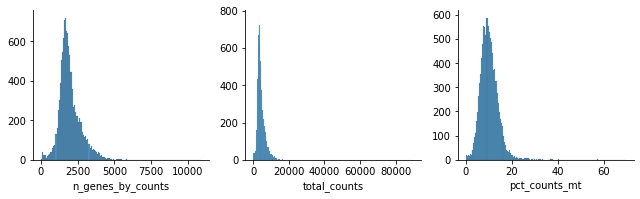

In [7]:
mu.pl.histogram(rna, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'])

Filter genes which expression is not detected:

In [8]:
mu.pp.filter_var(rna, 'n_cells_by_counts', lambda x: x >= 3)

Filter cells:

In [9]:
mu.pp.filter_obs(rna, 'n_genes_by_counts', lambda x: (x >= 200) & (x < 5000))

mu.pp.filter_obs(rna, 'total_counts', lambda x: x < 15000)
mu.pp.filter_obs(rna, 'pct_counts_mt', lambda x: x < 20)

Let's see how the data looks after filtering:

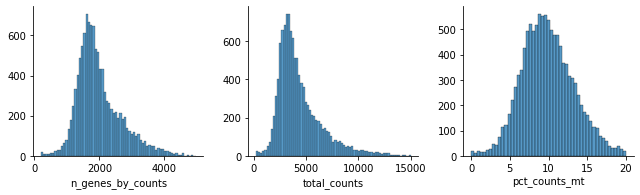

In [10]:
mu.pl.histogram(rna, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'])

### Normalisation and scaling

We'll save original counts in the `'counts'` layer:

In [11]:
rna.layers['counts'] = rna.X.copy()

We'll save log-normalised counts in the `'lognorm'` layer:

In [12]:
sc.pp.normalize_total(rna, target_sum=1e4)
sc.pp.log1p(rna)
rna.layers['lognorm'] = rna.X.copy()

Restore original counts for the following normalisation:

In [13]:
rna.X = rna.layers['counts'].copy()

In [14]:
def normalize_residuals(adata, inplace: bool = True, clip: bool = True, theta: int = 100):
    """
    Compute analytical residuals for NB model with a fixed theta. 
    Potentially clip outlier residuals to sqrt(N).

    Adapted from Lause et al., 2020.
    """
    n, d = adata.shape
    
    # Calculate sums
    # np.asarray() ensures they are ndarrays and not matrices
    counts_sum0 = np.asarray(np.sum(adata.X, axis=0).reshape(-1, d))
    counts_sum1 = np.asarray(np.sum(adata.X, axis=1).reshape(n, -1))
    counts_sum  = np.asarray(np.sum(adata.X))

    # Calculate residuals
    mu = counts_sum1 @ counts_sum0 / counts_sum
    z = np.array((adata.X - mu) / np.sqrt(mu + mu**2/theta))

    # Clip values 
    if clip:
        z[z >  np.sqrt(n)] =  np.sqrt(n)
        z[z < -np.sqrt(n)] = -np.sqrt(n)
    
    if not inplace:
        adata = adata.copy()
        
    adata.X = z

    return None if inplace else adata

We'll normalise the data so that we get Pearson residuals to work with.

In [15]:
%%time
normalize_residuals(rna)

CPU times: user 2.8 s, sys: 4.67 s, total: 7.47 s
Wall time: 7.49 s


## Analysis

Having filtered low-quality cells, normalised and scaled the counts matrix, we can run PCA, compute cell neighbourhood graph, and perform clustering to define cell types.

### PCA and neighbourhood graph

Here we run PCA on all of the genes having omitted the feature selection step.

In [16]:
%%time
sc.tl.pca(rna, svd_solver='arpack')

CPU times: user 40.5 s, sys: 1.45 s, total: 41.9 s
Wall time: 42 s


To visualise the result, we will use some markers for (large-scale) cell populations we expect to see such as T cells and NK cells (CD2), B cells (CD79A), and KLF4 (monocytes).

/home/bredikhi/.local/lib/python3.8/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])
... storing 'feature_types' as categorical
... storing 'genome' as categorical


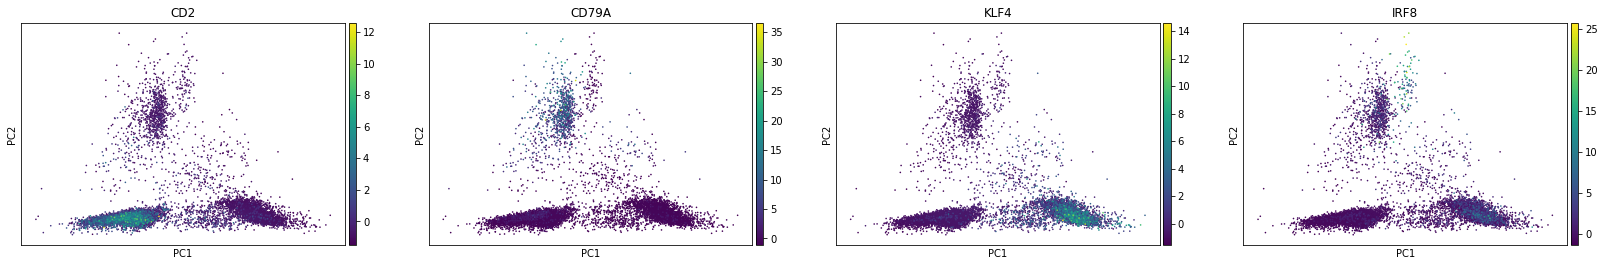

In [17]:
sc.pl.pca(rna, color=['CD2', 'CD79A', 'KLF4', 'IRF8'])

Use log-normalised coutns for visualisation purposes:

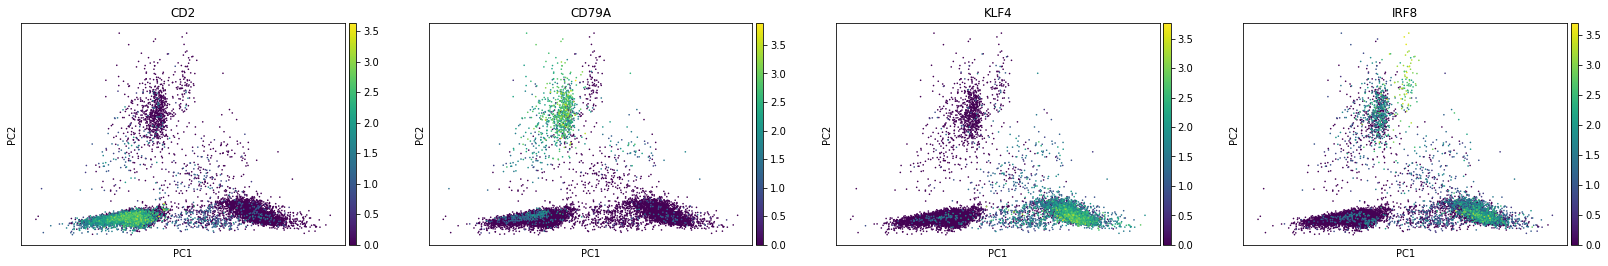

In [18]:
sc.pl.pca(rna, color=['CD2', 'CD79A', 'KLF4', 'IRF8'], layer='lognorm')

The first principal component (PC1) is separating myeloid (monocytes) and lymphoid (T, B, NK) cells while B cells-related features seem to drive the second one. Also we see plasmocytoid dendritic cells (marked by IRF8) being close to B cells along the PC2.

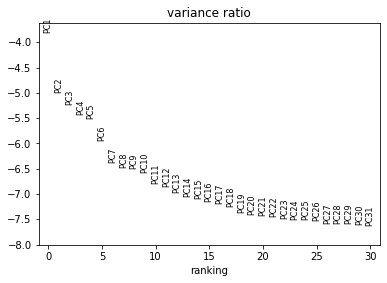

In [19]:
sc.pl.pca_variance_ratio(rna, log=True)

Now we can compute a neighbourhood graph for cells:

In [20]:
sc.pp.neighbors(rna, n_neighbors=10, n_pcs=20)

### Non-linear dimensionality reduction and clustering

With the neighbourhood graph computed, we can now perform clustering. We will use `leiden` clustering as an example.

In [21]:
sc.tl.leiden(rna, resolution=.4)

To visualise the results, we'll first generate a 2D latent space with cells that we can colour according to their cluster assignment.

In [22]:
sc.tl.umap(rna, spread=1., min_dist=.2, random_state=11)

/home/bredikhi/.local/lib/python3.8/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])


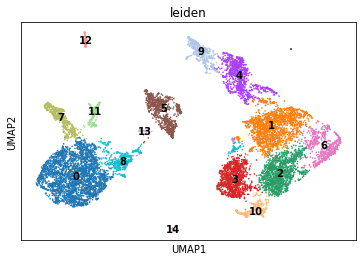

In [23]:
sc.pl.umap(rna, color="leiden", legend_loc="on data")

We can define finer cell types for clusters 4 and 5.

In [24]:
sc.tl.leiden(rna, restrict_to=('leiden', ['4']), key_added='leiden2', resolution=.15)
sc.tl.leiden(rna, restrict_to=('leiden2', ['5']), key_added='leiden2', resolution=.1)

/home/bredikhi/.local/lib/python3.8/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])


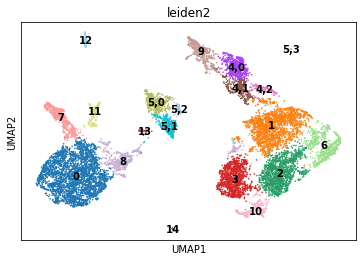

In [25]:
sc.pl.umap(rna, color="leiden2", legend_loc='on data')

### Marker genes and celltypes

In [26]:
sc.tl.rank_genes_groups(rna, 'leiden2', method='t-test_overestim_var')

/home/bredikhi/.local/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:407: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(


In [27]:
result = rna.uns['rank_genes_groups']
groups = result['names'].dtype.names
pd.set_option('display.max_columns', 50)
pd.DataFrame(
    {group + '_' + key[:1]: result[key][group]
    for group in groups for key in ['names', 'pvals']}).head(10)

,0_n,0_p,1_n,1_p,2_n,2_p,3_n,3_p,"4,0_n","4,0_p","4,1_n","4,1_p","4,2_n","4,2_p","5,0_n","5,0_p","5,1_n","5,1_p","5,2_n","5,2_p","5,3_n","5,3_p",6_n,6_p,7_n,7_p,8_n,8_p,9_n,9_p,10_n,10_p,11_n,11_p,12_n,12_p,13_n,13_p,14_n,14_p
0,DPYD,0.0,IL32,1.815558e-246,MALAT1,1.457943e-241,CD8B,3.141669e-147,CCL5,7.546624e-159,CCL5,6.133369e-53,SLC4A10,9.479709e-23,BANK1,8.481548e-203,IGHM,1.887981e-140,BANK1,3.326062e-22,JCHAIN,5.430103e-07,EEF1A1,1.199755e-243,PSAP,1.920177e-223,MTRNR2L12,7.867367e-20,GNLY,9.292045e-148,SERINC5,2.412485e-34,CD74,3.936541e-72,TCF4,3.321131e-50,BANK1,9.386434e-16,RNF220,3.036749e-09
1,PLXDC2,0.0,INPP4B,1.264691e-239,FHIT,2.318723e-173,LEF1,3.490700e-152,NKG7,2.297706e-162,SYNE2,1.315702e-37,PHACTR2,1.139782e-22,RALGPS2,1.702957e-140,AFF3,7.329143e-121,IGHM,1.621794e-19,PDIA4,1.729156e-06,RPL13,1.404841e-228,AIF1,5.566236e-152,PLXDC2,3.705267e-16,NKG7,1.848915e-147,CAMK4,3.428727e-33,CST3,6.207710e-56,UGCG,2.984554e-46,AFF3,6.449305e-13,RPLP0,3.574627e-08
2,NEAT1,0.0,RPL41,2.231338e-208,LEF1,2.748723e-166,PDE3B,7.916217e-144,GZMH,2.139408e-99,PRKCH,1.303833e-37,GZMK,5.431991e-22,CD74,2.284806e-154,BANK1,2.568864e-114,FCRL1,3.541754e-19,TENT5C,3.616165e-06,RPS12,4.490093e-208,TCF7L2,6.010913e-154,DPYD,1.094066e-14,PRF1,2.897182e-128,CCND3,1.918620e-32,HLA-DRA,4.130151e-57,RHEX,4.629092e-45,MS4A1,2.953311e-11,MSI2,2.548134e-07
3,ARHGAP26,0.0,LTB,3.310286e-198,BCL11B,2.071082e-159,NELL2,2.104626e-129,HLA-B,2.306112e-106,SYNE1,1.587070e-30,RORA,1.386351e-21,MS4A1,1.308589e-124,FCRL1,1.497325e-95,MS4A1,8.752592e-19,TXNDC5,2.855306e-05,RPL13A,8.383552e-213,CTSS,8.129490e-162,NEAT1,1.088570e-14,CD247,1.972445e-138,ARHGAP15,1.810680e-32,ACTB,2.666930e-58,PLD4,1.937591e-40,FCRL1,3.002825e-10,EEF1G,3.149335e-08
4,DENND1A,0.0,EEF1A1,1.175454e-198,CAMK4,1.242036e-144,THEMIS,2.605685e-131,GNLY,2.395793e-99,GZMK,8.010425e-28,KLRB1,2.043596e-19,OSBPL10,5.373950e-110,PAX5,6.586019e-82,PAX5,3.284385e-18,SUB1,2.014237e-05,RPS6,2.768714e-205,SERPINA1,8.839975e-145,CSF3R,5.495678e-14,KLRD1,6.514479e-106,BCL11B,8.436182e-32,HLA-DRB1,5.509964e-53,CCDC50,4.538694e-40,RALGPS2,3.374766e-10,ZNRF1,4.838011e-07
5,FCN1,0.0,ITGB1,5.158475e-182,TCF7,1.044652e-135,OXNAD1,5.330609e-115,GZMA,1.351470e-91,PIP4K2A,6.091719e-27,A2M,2.651936e-19,CD79A,3.373959e-110,IGHD,7.539770e-79,AFF3,1.722321e-18,AL589693.1,2.408736e-05,RPS3A,1.934906e-196,LST1,1.618156e-136,AC020916.1,2.236303e-13,GZMA,3.183985e-95,DOCK10,2.915073e-31,HLA-DQA1,1.464471e-51,IRF8,3.289786e-41,IGHM,2.153356e-10,HNRNPA1,4.937405e-07
6,LRMDA,0.0,RPL13,4.795952e-183,CCR7,9.544027e-117,NDFIP1,2.582644e-113,HLA-C,1.444012e-92,SAMD3,1.400036e-26,KLRG1,2.721390e-18,AFF3,8.683034e-119,CD74,2.380170e-94,RALGPS2,2.180217e-16,TPD52,1.219271e-05,RPL21,1.973402e-190,COTL1,3.015392e-144,TBXAS1,2.863929e-13,CTSW,1.377005e-94,PRKCH,2.896252e-28,SAMHD1,5.578314e-53,FCHSD2,6.081512e-40,MARCH1,2.155821e-10,CHRM3,9.392011e-07
7,AOAH,0.0,B2M,2.712954e-182,MAML2,8.547797e-110,CCR7,3.863509e-112,B2M,1.183403e-89,SKAP1,4.253590e-27,ZBTB16,2.492584e-17,EBF1,1.062917e-105,BACH2,1.135843e-81,LINC00926,1.537761e-15,ITM2C,1.204192e-04,RPL19,2.563000e-186,IFITM3,2.911609e-133,DMXL2,1.213916e-12,KLRF1,1.630845e-89,ITK,9.742718e-27,GRN,2.557183e-50,RABGAP1L,1.875553e-42,ARHGAP24,2.501646e-09,ST8SIA6,1.030612e-06
8,JAK2,0.0,CDC14A,1.709815e-175,ANK3,7.273358e-103,BACH2,1.168973e-110,SYNE1,5.658589e-84,PZP,5.702920e-26,ADAM12,2.183838e-15,PAX5,3.727639e-107,LINC00926,6.500239e-77,CD79B,9.686754e-14,IFNG-AS1,4.462318e-05,RPS25,8.796396e-186,MTSS1,5.202087e-134,DENND1A,1.956877e-12,MCTP2,2.323553e-92,THEMIS,1.637465e-25,HLA-DPB1,3.995528e-42,PTPRS,1.533924e-35,PAX5,1.202612e-08,NKAIN2,2.147855e-06
9,TYMP,0.0,RPS2,4.365109e-180,PRKCA,4.719588e-99,CD8A,3.166832e-106,IL32,7.358525e-86,A2M,5.548610e-26,SYNE2,7.915018e-17,BLK,2.408433e-100,RALGPS2,4.399955e-79,CD79A,1.336525e-13,MZB1,2.492218e-04,RPLP2,8.544219e-183,WARS,1.731208e-138,SLCO3A1,1.548942e-11,CST7,5.428710e-87,PITPNC1,1.707940e-25,HLA-DRB5,1.011036e-42,

Exploring the data we notice clusters 8, 13, and 5,2 seem to be composed of cells bearing markers for different cell lineages so likely to be noise (e.g. doublets). Cluster 6 has higher ribosomal gene expression when compared to other clusters. Cluster 10 seem to consist of proliferating cells, cluster 14 — of stressed cells.

We will remove cells from these clusters before assigning cell types names to clusters.

In [28]:
mu.pp.filter_obs(rna, "leiden2", lambda x: ~x.isin(["8", "13", "5,2", "6", "14", "10"]))

In [48]:
new_cluster_names = {
    "1": "CD4+ memory T", "2": "CD4+ naïve T", "3": "CD8+ naïve T", 
    "4,0": "CD8+ cytotoxic effector T", "4,1": "CD8+ transitional effector T", "4,2": "MAIT", "9": "NK",
    "5,1": "naïve B", "5,0": "memory B", "5,3": "plasma B",
    "0": "classical mono", "7": "non-classical mono",
    "11": "mDC", "12": "pDC",
}

rna.obs['celltype'] = rna.obs.leiden2.astype("str").values
rna.obs.celltype = rna.obs.celltype.astype("category")
rna.obs.celltype = rna.obs.celltype.cat.rename_categories(new_cluster_names)

We will also re-order categories for the next plots:

In [49]:
rna.obs.celltype.cat.reorder_categories([
    'CD4+ naïve T', 'CD4+ memory T',
    'CD8+ naïve T', 'MAIT',
    'CD8+ cytotoxic effector T', 'CD8+ transitional effector T', 'NK',
    'naïve B', 'memory B', 'plasma B',
    'classical mono', 'non-classical mono',
    'mDC', 'pDC'], inplace=True)

... and take colours from a palette:

In [50]:
import matplotlib
import matplotlib.pyplot as plt

cmap = plt.get_cmap('rainbow')
colors = cmap(np.linspace(0, 1, len(rna.obs.celltype.cat.categories)))

rna.uns["celltype_colors"] = list(map(matplotlib.colors.to_hex, colors))

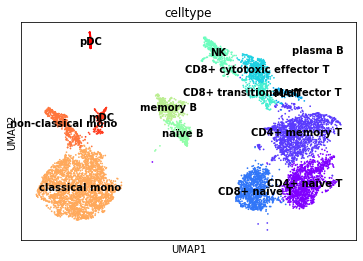

In [51]:
sc.pl.umap(rna, color="celltype", legend_loc="on data")

Finally, we'll visualise some marker genes across cell types.

In [52]:
marker_genes = [
    'IL7R', 'TRAC', 'GATA3',                                # CD4+ T
    'LEF1', 'FHIT', 'RORA', 'ITGB1',                        # naïve/memory
    'CD8A', 'CD8B', 'CD248', 'CCL5',                        # CD8+ T
    'GZMH', 'GZMK',                                         # cytotoxic/transitional effector T cells
    'KLRB1', 'SLC4A10',                                     # MAIT
    'IL32',                                                 # T/NK
    'GNLY', 'NKG7',                                         # NK
    'CD79A', 'MS4A1', 'IGHD', 'IGHM', 'IL4R', 'TNFRSF13C',  # B
    'JCHAIN',                                               # plasma
    'KLF4', 'LYZ', 'S100A8', 'ITGAM', 'CD14',               # mono
    'DPYD', 'ITGAM',                                        # classical/intermediate/non-classical mono
    'FCGR3A', 'MS4A7', 'CST3',                              # non-classical mono
    'CLEC10A', 'IRF8', 'TCF4'                               # DC
]

/home/bredikhi/.local/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


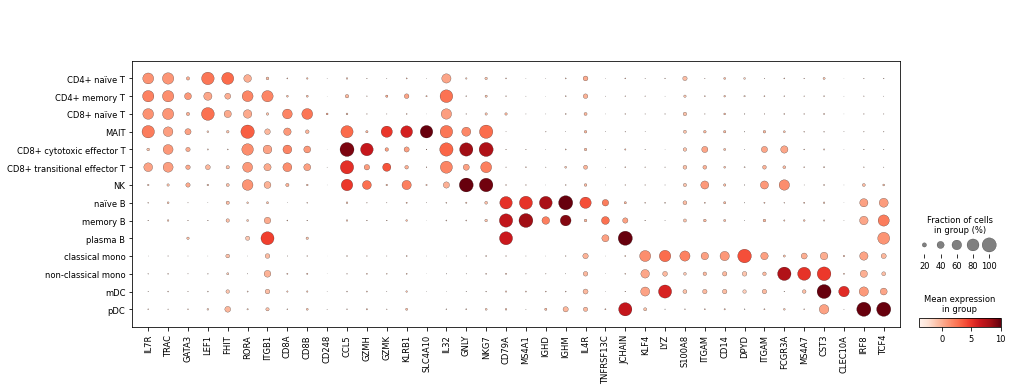

In [53]:
sc.pl.dotplot(rna, marker_genes, groupby='celltype', vmax=10)

## Saving data on disk

In [54]:
rna.write("data/pbmc10k_rna.h5ad")

/home/bredikhi/.local/lib/python3.8/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])
